-Prepare solution to build ticketing system there by using json file as your primary datasource (Text corpus with other metadata in it). 
Step 1: Group data into five categories namely Banking services, loans, Fraudalent reporting, Card, others.
Step 2: From step 1 create labeled dataset and utilize it to train supervised model like logistic regression, decision tree or random forest.


Above excercise should follow these steps -
1)Load Data
2)Text Preprocessing
3)EDA
4)Feature Extraction
5)Topic Modelling (Unsupervised)
6)Model building using Supervised learning
7)Model Training and evaluation
8)Inference

In [134]:
import numpy as np 
import pandas as pd 
import nltk 
import spacy
from google.colab import drive
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition  
from nltk.stem import WordNetLemmatizer
from copy import deepcopy
from sklearn.decomposition import NMF
import wordcloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score  
from sklearn.metrics import confusion_matrix 

In [135]:
#nltk.download('all')

1) Load Data 

In [ ]:
data=pd.read_json('/content/drive/MyDrive/Assignment Persistent/Client_data.json')


In [ ]:
df=json_normalize(data['_source']) 

<ipython-input-3-3d2b1153d9a6>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df=json_normalize(data['_source'])


In [ ]:
df.head()

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


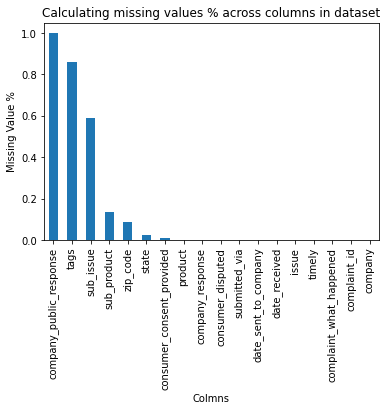

In [ ]:
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Colmns')
plt.ylabel('Missing Value %')
plt.title('Calculating missing values % across columns in dataset')
plt.show()

In [ ]:
#Columns with more importance
df[['product','sub_product','sub_issue','complaint_what_happened']]
#these four columns consists of the major data in the data frame 
#As we can see from here there are areas where there are no values in complaint_what_happened and sub_issue
#Hence merging both columns to fill null values 

,product,sub_product,sub_issue,complaint_what_happened
0,Debt collection,Credit card debt,Debt is not yours,
1,Debt collection,Credit card debt,Didn't receive enough information to verify debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,General-purpose credit card or charge card,Problem with rewards from credit card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage,Conventional home mortgage,None,
4,Credit card or prepaid card,General-purpose credit card or charge card,Charged too much interest,
...,...,...,...,...
78308,Checking or savings account,Checking account,Funds not received from closed account,
78309,Credit card or prepaid card,General-purpose credit card or charge card,Other problem,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,Checking or savings account,Checking account,Transaction was not authorized,I am not familiar with XXXX pay and did not un...
78311,Credit card or prepaid card,General-purpose credit card or charge card,Problem with balance transfer,I have had flawless credit for 30 yrs. I've ha...


In [ ]:

# creating corpus 
df['Corpus']=df['sub_issue'].astype(str)+' '+df['complaint_what_happened'].astype(str)

Cleaning data 
1) Removing Punctuation and Symbols 

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def tokenize(text):
  tokens=[word for word in nltk.word_tokenize(text) if (len(word)>3 and len (word.strip('Xx/'))>2)]
  lemmatiz_=[lemmatizer.lemmatize(x) for x in tokens]
  return tokens

In [ ]:
vectorizer_tf=TfidfVectorizer(tokenizer=tokenize,stop_words='english',max_df=0.75,min_df=50,max_features=10000,use_idf=False,norm=None)
tf_vectors=vectorizer_tf.fit_transform(df['Corpus'])

In [ ]:
tf_vectors.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#vectorizer_tf.get_feature_names()

In [ ]:
nmf_model=NMF(n_components=5,random_state=42)

In [ ]:
nmf_model.fit(tf_vectors)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=5, random_state=42)

In [ ]:
for index,topic in enumerate(nmf_model.components_):
    print(f'The Top 15 words for the topic #{index}')
    print([vectorizer_tf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')
#Banking services, loans, Fraudalent reporting, Card, others

The Top 15 words for the topic #0
['issue', 'refund', 'agent', 'provided', 'charge', 'dispute', 'sent', 'complaint', 'case', 'customer', 'fraud', 'letter', 'received', 'bank', 'chase']


The Top 15 words for the topic #1
['time', 'charged', 'statement', 'said', 'company', 'received', 'dispute', 'fraud', 'called', 'charge', 'told', 'purchase', 'charges', 'credit', 'card']


The Top 15 words for the topic #2
['asked', 'deposit', 'number', 'accounts', 'branch', 'checking', 'called', 'said', 'closed', 'told', 'funds', 'check', 'money', 'bank', 'account']


The Top 15 words for the topic #3
['agency', 'score', 'balance', 'request', 'collection', 'late', 'fair', 'debt', 'payment', 'consumer', 'account', 'information', 'reporting', 'report', 'credit']


The Top 15 words for the topic #4
['asked', 'sent', 'letter', 'modification', 'received', 'called', 'home', 'said', 'time', 'bank', 'payments', 'told', 'mortgage', 'payment', 'loan']




/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


From Above we can map Topic 0:Fraudulent Reporting, Topic 1: Cards,Topic2:Banking,Topic 3: Loan,Topic 4:Others

In [ ]:
topic_results=nmf_model.transform(tf_vectors)

In [ ]:
topic_results.argmax(axis=1)

array([3, 0, 1, ..., 0, 0, 3])

In [ ]:
df['Topics']=topic_results.argmax(axis=1)

In [ ]:
df.columns

Index(['tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'company',
       'submitted_via', 'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided', 'Corpus', 'Topics'],
      dtype='object')

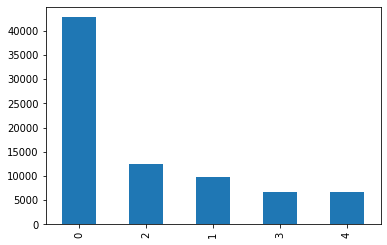

In [ ]:
#EDA 
df['Topics'].value_counts().plot(kind='bar')
plt.show()
#this is an imbalanced dataset 

In [ ]:
df['company'].value_counts()# this column does not hold any relevance to the target variable 

JPMORGAN CHASE & CO.    78313
Name: company, dtype: int64

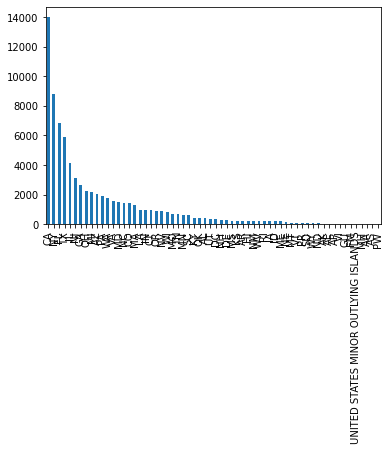

In [ ]:
df['state'].value_counts().plot(kind='bar')
#This shows that maximum cases are from California

In [ ]:
pd.DataFrame(df.groupby(['submitted_via','product','Topics'])['complaint_id'].count())

complaint_id
submitted_via product                     Topics              
Email         Bank account or service     0                  4
              Checking or savings account 1                  1
              Credit card                 0                  4
              Credit card or prepaid card 1                  1
              Mortgage                    0                 15
...                                                        ...
Web           Vehicle loan or lease       0                117
                                          1                 75
                                          2                 53
                                          3                 85
                                          4                306

[217 rows x 1 columns]

In [ ]:
df.groupby(['state','submitted_via'])['complaint_id'].count().sort_values(ascending=False)
#this shows that urban areas prefer web more than other modes of communication 

state  submitted_via
CA     Web              8769
NY     Web              4992
FL     Web              3974
TX     Web              3914
CA     Referral         3595
                        ... 
UT     Email               1
MH     Postal mail         1
MO     Email               1
AE     Phone               1
VI     Postal mail         1
Name: complaint_id, Length: 284, dtype: int64

In [136]:
df['date_sent_to_company'][0]

'2019-04-13T12:00:00-05:00'

In [ ]:
df['Date_']=df['date_sent_to_company'].apply(lambda x:x.split("T")[0])

In [ ]:
df['Date_'].value_counts()

2012-06-21    105
2014-02-10     70
2012-06-15     68
2014-02-24     66
2012-07-03     65
             ... 
2013-08-17      1
2011-12-04      1
2013-05-11      1
2014-08-03      1
2012-06-17      1
Name: Date_, Length: 3309, dtype: int64

In [ ]:
df['Cohorts']=df['Date_'].apply(lambda x:x[:7])

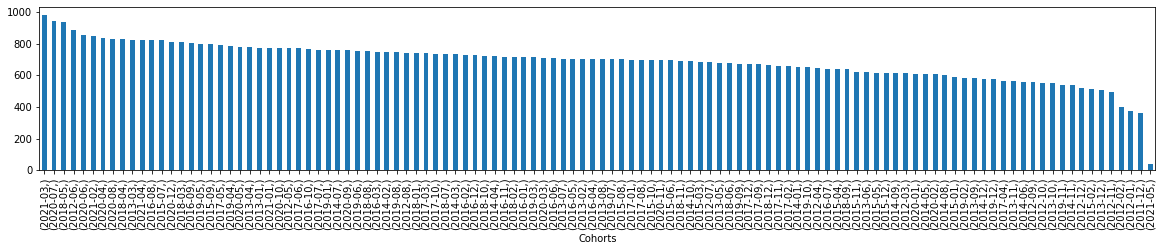

In [137]:
plt.rcParams["figure.figsize"] = (20,3)
df[['Cohorts']].value_counts().plot(kind='bar')
#cohorts show a higher relevance overall

In [ ]:
pd.DataFrame(df[['Cohorts','state']].value_counts())

0
Cohorts state     
2020-06 CA     190
2020-07 CA     180
2018-05 CA     178
2021-03 CA     171
2020-04 CA     164
...            ...
2015-04 WV       1
        NH       1
        NE       1
2020-05 ID       1
2011-12 AK       1

[5195 rows x 1 columns]

In [ ]:
df['Year']=df['Date_'].apply(lambda x:x[:4])

In [ ]:
df.groupby(['Year','Topics'])['complaint_id'].count()
#this shows that for initial years the matters reported were in topic 0 but post 2017 there is a rising trend in the banking and card related problems 

Year  Topics
2011  0          359
2012  0         7222
      1            1
      2            1
      3            2
2013  0         7818
      1            1
      2            4
      3           68
      4           85
2014  0         6990
      1           28
      2           25
      3          305
      4          436
2015  0         5887
      1          273
      2          417
      3          466
      4          929
2016  0         6069
      1          435
      2          660
      3          701
      4          908
2017  0         2943
      1         1518
      2         1924
      3          998
      4         1013
2018  0         1764
      1         2209
      2         2670
      3         1254
      4         1007
2019  0         1555
      1         2084
      2         2619
      3         1054
      4          952
2020  0         1635
      1         2324
      2         3014
      3         1275
      4          951
2021  0          550
      1          866


In [ ]:
df.groupby(['Year','issue'])['complaint_id'].count()

Year  issue                                                 
2011  APR or interest rate                                      30
      Advertising and marketing                                  7
      Application processing delay                               1
      Application, originator, mortgage broker                  22
      Balance transfer                                           5
                                                                ..
2021  Unable to get your credit report or credit score           4
      Unauthorized transactions or other transaction problem    13
      Unexpected or other fees                                   8
      Written notification about debt                           35
      Wrong amount charged or received                           3
Name: complaint_id, Length: 762, dtype: int64

In [ ]:
df.columns

Index(['tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'company',
       'submitted_via', 'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided', 'Corpus', 'Topics', 'Date_', 'Time_',
       'Cohorts', 'Year'],
      dtype='object')

In [ ]:
df['company_response'].value_counts()

Closed with explanation            60230
Closed with monetary relief        10129
Closed with non-monetary relief     4383
Closed without relief               2009
Closed with relief                   813
Closed                               628
In progress                          119
Untimely response                      2
Name: company_response, dtype: int64

In [ ]:
selected_features=['Cohorts','product','state','issue','company_response','Topics']

In [ ]:
round((df[selected_features].isnull().sum()/df.shape[0])*100,2)
#2.54% null values in the selected colmn state 

Cohorts             0.00
product             0.00
state               2.54
issue               0.00
company_response    0.00
Topics              0.00
dtype: float64

In [ ]:
df2=df[selected_features]
#replacing the null value with 'CA' in state
df2['state'].fillna('CA',inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [182]:
X = pd.get_dummies(df2.drop(['issue','company_response'],axis=1), columns = ['Cohorts','product','state']).drop('Topics',axis=1)
y=df2['Topics']

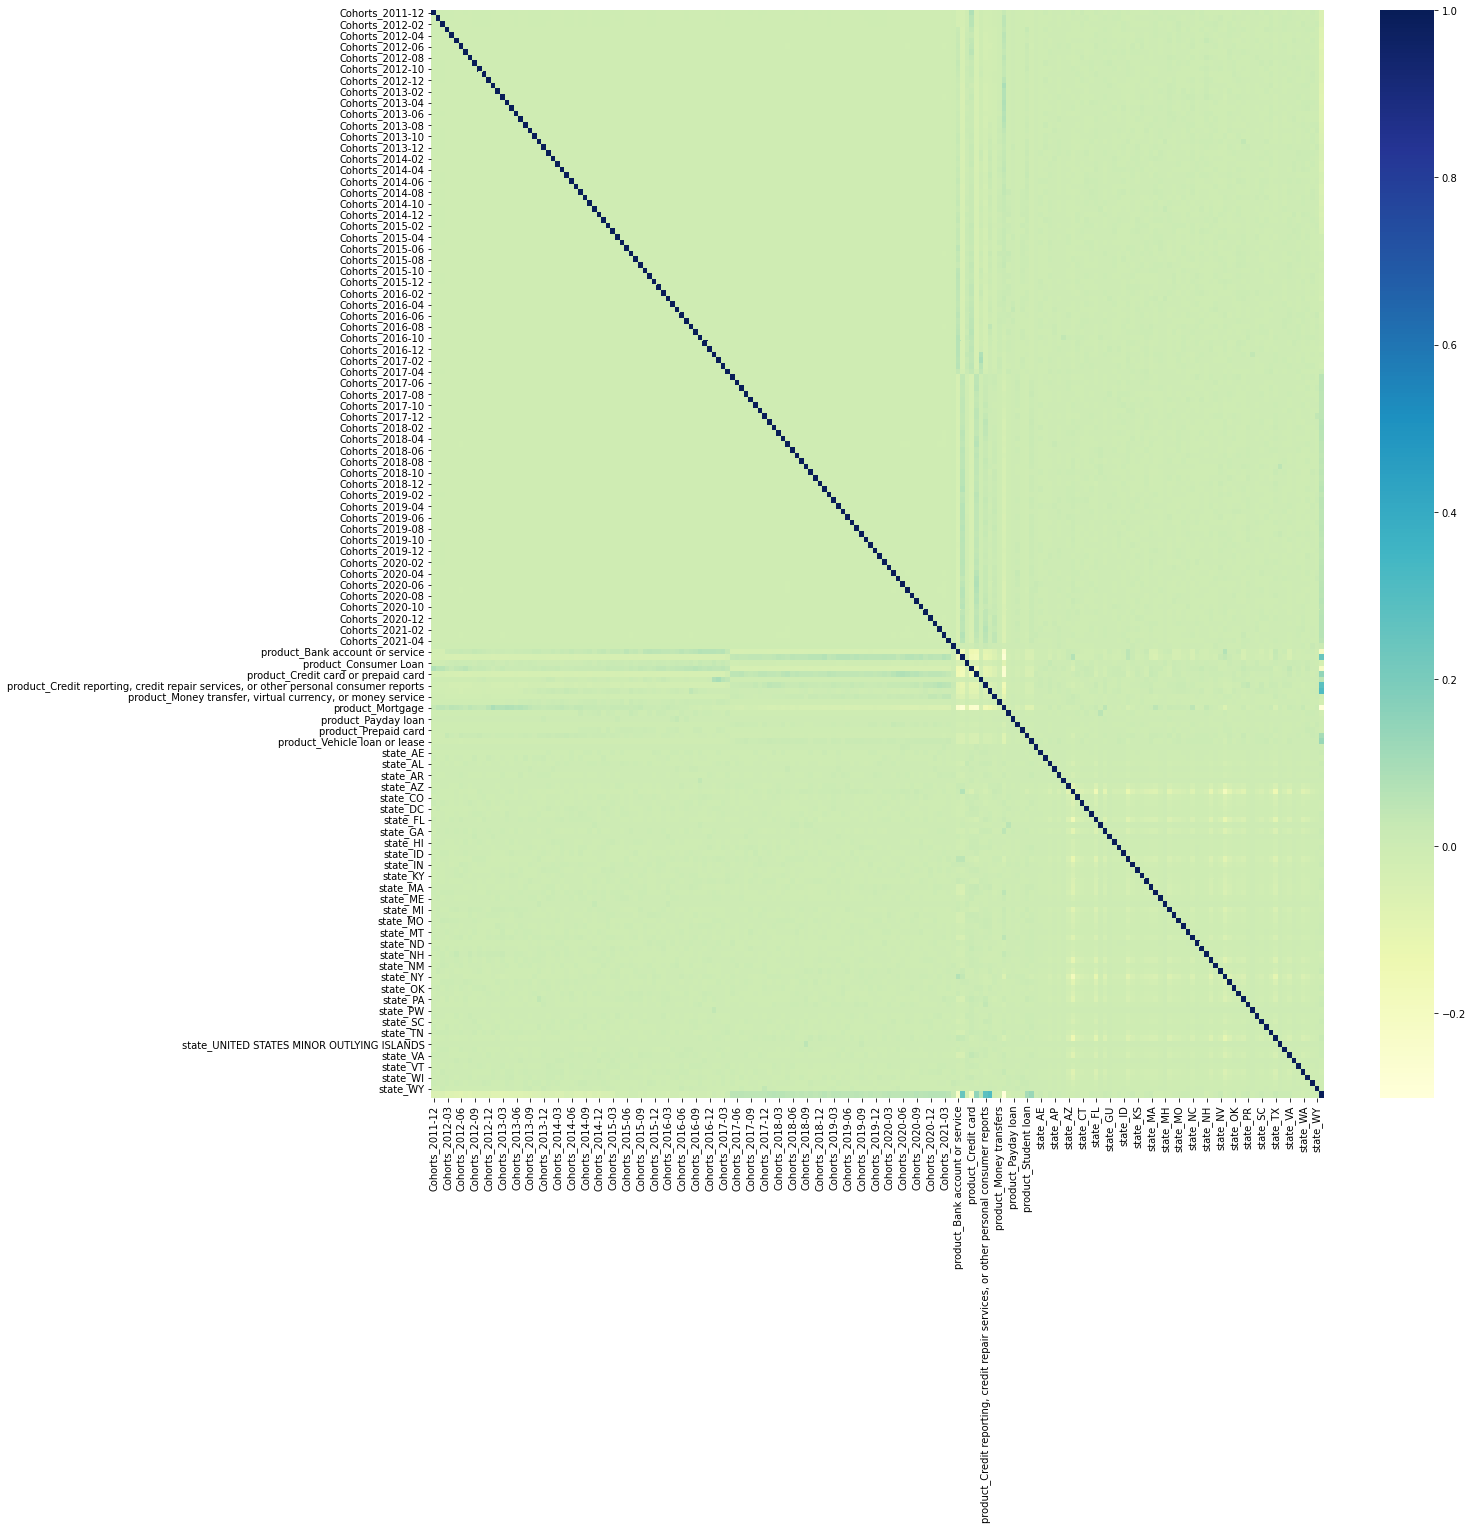

In [184]:
import seaborn as sb
plt.rcParams["figure.figsize"] = (20,20)
data_1=X
data_1['Topics']=y
dataplot = sb.heatmap(data_1.corr(), cmap="YlGnBu", annot=False)
plt.show()

In [185]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,random_state=42, test_size=0.30, shuffle=True)

In [186]:
gnb = GaussianNB().fit(X_train, y_train)

In [187]:
gnb_predictions = gnb.predict(X_test)

In [142]:
len(gnb_predictions),len(y_test)

(23494, 23494)

In [188]:
f1_score(y_test, gnb_predictions,pos_label='positive',average='micro')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.999744615646548

In [189]:
from sklearn.metrics import classification_report
classification_report(y_test, gnb_predictions,target_names=['class 0','class 1','class 2','class 3','class 4'])

'              precision    recall  f1-score   support\n\n     class 0       1.00      1.00      1.00     12824\n     class 1       1.00      1.00      1.00      2870\n     class 2       1.00      1.00      1.00      3709\n     class 3       1.00      1.00      1.00      2069\n     class 4       1.00      1.00      1.00      2022\n\n    accuracy                           1.00     23494\n   macro avg       1.00      1.00      1.00     23494\nweighted avg       1.00      1.00      1.00     23494\n'

In [190]:
confusion_matrix(y_test, gnb_predictions)

array([[12824,     0,     0,     0,     0],
       [    0,  2870,     0,     0,     0],
       [    0,     0,  3708,     1,     0],
       [    0,     0,     5,  2064,     0],
       [    0,     0,     0,     0,  2022]])

Scores are fairly poor due to high imbalance in the data set let's try oversampling to solve this problem 

In [144]:
from imblearn.over_sampling import SMOTE

In [192]:
oversample = SMOTE()
X1, y1 = oversample.fit_resample(X_train, y_train)


In [148]:
y1.value_counts()# y values has been oversampeled considerably let's train the model now 

0    29968
3    29968
2    29968
4    29968
1    29968
Name: Topics, dtype: int64

In [193]:
y_train.value_counts()

0    29968
2     8737
1     6869
3     4657
4     4588
Name: Topics, dtype: int64

In [194]:
gnb2 = GaussianNB().fit(X1, y1)

In [195]:
gnb_predictions2 = gnb2.predict(X_test)

In [196]:
f1_score(y_test, gnb_predictions2,pos_label='positive',average='micro')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.9997871797054567

In [197]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb2, X_test, y_test)
print(imps.importances_mean)

[ 8.51281178e-06  8.51281178e-06  5.10768707e-05  2.55384353e-05
  4.25640589e-05  4.25640589e-05  2.55384353e-05  6.81024943e-05
  4.25640589e-05  2.55384353e-05  3.40512471e-05  0.00000000e+00
  3.40512471e-05  3.40512471e-05  4.25640589e-05  5.10768707e-05
  4.25640589e-05  5.95896825e-05  3.40512471e-05  5.95896825e-05
  4.25640589e-05  2.55384353e-05  1.70256236e-05  6.81024943e-05
  2.55384353e-05  0.00000000e+00  0.00000000e+00  1.70256236e-05
  0.00000000e+00  1.70256236e-05  3.40512471e-05  5.10768707e-05
  2.55384353e-05  0.00000000e+00  4.25640589e-05  1.70256236e-05
  0.00000000e+00  0.00000000e+00  3.40512471e-05  1.70256236e-05
  0.00000000e+00  0.00000000e+00 -8.51281178e-06  0.00000000e+00
  1.70256236e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.51281178e-06  0.00000000e+00  0.00000000e+00
  8.51281178e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000